# Datacube Access Demonstration

The Datacube Access building block provides access to multi-dimensional Earth Observation data 
through a filtered STAC API. It exposes only collections that include the STAC Datacube Extension
(those with `cube:dimensions` or `cube:variables` defined), ensuring that downstream tools like 
openEO receive properly-structured, analysis-ready data.

This notebook demonstrates:
- Validating the Datacube Access endpoints
- Exploring datacube-ready collections and their dimensional metadata
- Loading STAC items into xarray datacubes using odc-stac

## Setup

In [1]:
import os
import requests
import json
import matplotlib.pyplot as plt
import pystac
import odc.stac

import sys
sys.path.append('../')
from modules.helpers import load_eoepca_state, test_cell, test_results

Load `eoepca state` environment

In [2]:
load_eoepca_state()

In [3]:
platform_domain = os.environ.get("INGRESS_HOST")
datacube_access_url = f'https://datacube-access.{platform_domain}'
collection_id = 'sentinel-2-datacube'

log_output_file = "datacube_access_log.json"

print(f"Datacube Access URL: {datacube_access_url}")

Datacube Access URL: https://datacube-access.test.eoepca.org


## Validate Datacube Access Endpoints

The Datacube Access BB provides standard OGC API endpoints. These should all return 200 status codes.

In [4]:
endpoints = [
    ("Landing Page", datacube_access_url),
    ("OpenAPI Documentation", f"{datacube_access_url}/docs"),
    ("Collections", f"{datacube_access_url}/collections"),
    ("Conformance", f"{datacube_access_url}/conformance"),
]

for name, url in endpoints:
    response = requests.get(url)
    print(f"{name}: {response.status_code}")

Landing Page: 200
OpenAPI Documentation: 200
Collections: 200
Conformance: 200


## Explore Available Collections

The Datacube Access BB acts as a filter over the underlying STAC catalogue (eoapi). It only 
exposes collections that include the STAC Datacube Extension - specifically those containing 
`cube:dimensions` or `cube:variables` in their metadata.

This filtering is important because it ensures that processing tools like openEO only see 
collections that have the structural metadata needed to interpret data as multidimensional 
datacubes.

In [5]:
collections_url = f"{datacube_access_url}/collections"
response = requests.get(collections_url)

collections = response.json().get("collections", [])
print(f"Datacube-ready collections: {len(collections)}\n")

for collection in collections:
    coll_id = collection.get('id')
    title = collection.get('title', 'N/A')
    
    # Check which datacube metadata is present
    has_dimensions = "cube:dimensions" in collection
    has_variables = "cube:variables" in collection
    
    print(f"ID: {coll_id}")
    print(f"Title: {title}")
    print(f"Has cube:dimensions: {has_dimensions}")
    print(f"Has cube:variables: {has_variables}")
    print()

Datacube-ready collections: 3

ID: datacube-ready-collection
Title: Sentinel-2 L2A Analysis Ready Datacube
Has cube:dimensions: True
Has cube:variables: False

ID: sentinel-2-datacube
Title: Sentinel-2 L2A Datacube
Has cube:dimensions: True
Has cube:variables: True

ID: sentinel-2-l2a-datacube
Title: Sentinel-2 L2A Datacube
Has cube:dimensions: True
Has cube:variables: True



## Inspect Collection Datacube Metadata

Datacube-ready collections include structural metadata that describes how the data is organised.
This metadata tells processing tools:
- What dimensions exist (spatial x/y, time, bands)
- The coordinate reference system
- The extent of each dimension
- What variables are available and their relationships to dimensions

In [6]:
collection_url = f"{datacube_access_url}/collections/{collection_id}"
response = requests.get(collection_url)
collection_metadata = response.json()

print(f"Collection: {collection_id}")
print(f"Title: {collection_metadata.get('title', 'N/A')}")
print(f"\nSpatial extent: {collection_metadata.get('extent', {}).get('spatial', {})}")
print(f"Temporal extent: {collection_metadata.get('extent', {}).get('temporal', {})}")

Collection: sentinel-2-datacube
Title: Sentinel-2 L2A Datacube

Spatial extent: {'bbox': [[-34.2, 39.65, -32.88, 41.55]]}
Temporal extent: {'interval': [['2025-10-30T00:00:00Z', '2025-10-30T23:59:59Z']]}


In [7]:
# Inspect the cube:dimensions - these define the axes of the datacube
if "cube:dimensions" in collection_metadata:
    print("cube:dimensions:")
    print(json.dumps(collection_metadata["cube:dimensions"], indent=2))

cube:dimensions:
{
  "x": {
    "axis": "x",
    "type": "spatial",
    "extent": [
      399960,
      509760
    ],
    "reference_system": 32625
  },
  "y": {
    "axis": "y",
    "type": "spatial",
    "extent": [
      4390220,
      4600020
    ],
    "reference_system": 32625
  },
  "time": {
    "type": "temporal",
    "extent": [
      "2025-10-30T00:00:00Z",
      "2025-10-30T23:59:59Z"
    ]
  },
  "bands": {
    "type": "bands",
    "values": [
      "B04",
      "B08",
      "SCL"
    ]
  }
}


In [8]:
# Inspect cube:variables if present - these describe the data variables and which dimensions they use
if "cube:variables" in collection_metadata:
    print("cube:variables:")
    print(json.dumps(collection_metadata["cube:variables"], indent=2))

cube:variables:
{
  "B04": {
    "type": "data",
    "unit": "1",
    "dimensions": [
      "x",
      "y",
      "time"
    ],
    "description": "Red band (665nm)"
  },
  "B08": {
    "type": "data",
    "unit": "1",
    "dimensions": [
      "x",
      "y",
      "time"
    ],
    "description": "NIR band (842nm)"
  },
  "SCL": {
    "type": "auxiliary",
    "unit": "1",
    "dimensions": [
      "x",
      "y",
      "time"
    ],
    "description": "Scene Classification Layer"
  }
}


The dimensions above map directly to how the data will be structured when loaded into xarray:
- `x` and `y` become spatial coordinates
- `time` becomes the temporal dimension  
- `bands` determines which data variables are available (B04, B08, SCL in this case)

## Retrieve Items from the Collection

In [9]:
# Get items URL from collection links
items_url = None
for link in collection_metadata.get("links", []):
    if link.get("rel") == "items":
        items_url = link.get("href")
        break

print(f"Fetching items from: {items_url}")
response = requests.get(items_url, params={"limit": 10})

items_data = response.json()
items = items_data.get("features", [])

print(f"Found {len(items)} items\n")

for item in items[:5]:
    item_id = item.get("id")
    props = item.get("properties", {})
    datetime_val = props.get("datetime", "N/A")
    print(f"  {item_id}: {datetime_val}")

Fetching items from: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-datacube/items
Found 2 items

  S2C_T25TDE_20251030T131038_L2A: 2025-10-30T13:11:10Z
  S2C_T25TDF_20251030T131038_L2A: 2025-10-30T13:10:55Z


## Load Data as xarray Datacube

The odc-stac library can load STAC items directly into an xarray Dataset. This is the 
"pangeo" approach mentioned in the EOEPCA documentation - using STAC for discovery and 
xarray for analysis.

We need to specify:
- The coordinate reference system (using the native CRS from cube:dimensions)
- A resolution (100m here for faster loading; native Sentinel-2 is 10m)

In [ ]:
# Convert JSON items to pystac Item objects
pystac_items = [pystac.Item.from_dict(item) for item in items[:1]]

ds = odc.stac.load(
    pystac_items,
    crs="EPSG:32625",  # From cube:dimensions reference_system
    resolution=100,    # 100m for faster loading 
    bands=["B04", "B08"],
)

print("Datacube structure:")
print(ds)

Datacube structure:
<xarray.Dataset> Size: 10MB
Dimensions:      (y: 1101, x: 1099, time: 1)
Coordinates:
  * y            (y) float64 9kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
  * x            (x) float64 9kB 4e+05 4e+05 4.002e+05 ... 5.096e+05 5.098e+05
    spatial_ref  int32 4B 32625
  * time         (time) datetime64[ns] 8B 2025-10-30T13:11:10
Data variables:
    B04          (time, y, x) float32 5MB nan nan nan nan ... nan nan nan nan
    B08          (time, y, x) float32 5MB nan nan nan nan ... nan nan nan nan


Notice how the xarray Dataset structure mirrors the `cube:dimensions` metadata:
- `x` and `y` coordinates match the spatial dimensions
- `time` coordinate from the temporal dimension
- Data variables (B04, B08) as specified in the bands dimension

## Visualise the Data

B04 value range: 989.0 to 16096.0


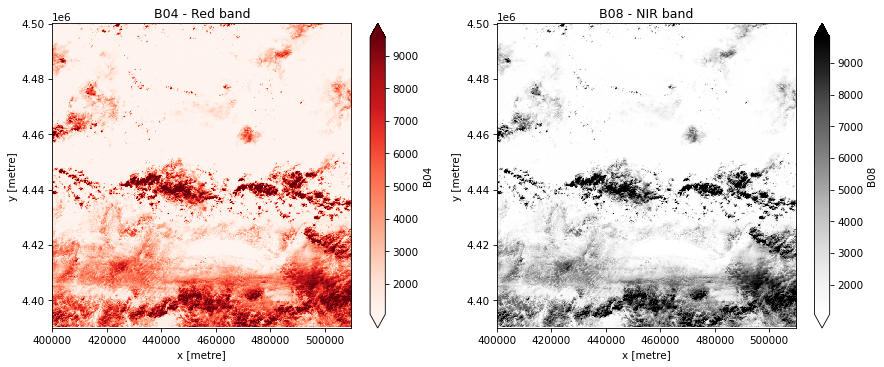

In [11]:
# Check we have actual data values
b04_min = float(ds['B04'].min())
b04_max = float(ds['B04'].max())
print(f"B04 value range: {b04_min} to {b04_max}")

if ds['B04'].notnull().any():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=75)
    
    ds['B04'].isel(time=0).plot.imshow(ax=axes[0], cmap="Reds", robust=True)
    axes[0].set_title("B04 - Red band")
    
    ds['B08'].isel(time=0).plot.imshow(ax=axes[1], cmap="Greys", robust=True)
    axes[1].set_title("B08 - NIR band")
    
    plt.tight_layout()
else:
    print("No valid data found - check asset accessibility")

## Conformance Classes

The conformance endpoint shows which OGC API standards the service implements.

In [12]:
conformance_url = f"{datacube_access_url}/conformance"
response = requests.get(conformance_url)

conformance = response.json()
print("Supported conformance classes:\n")
for cls in conformance.get("conformsTo", []):
    # Just show the standard name, not full URL
    print(f"  {cls.split('/')[-1]}")

Supported conformance classes:

  geodatacube-api
  basic-cql2
  cql2-json
  cql2-text
  simple-query
  core
  geojson
  oas30
  features-filter
  filter
  collection-search
  collection-search#fields
  collection-search#filter
  collection-search#free-text
  collection-search#query
  collection-search#sort
  item-search#filter
  collections
  transaction
  core
  item-search
  item-search#fields
  item-search#query
  item-search#sort
  ogcapi-features
  ogcapi-features#fields
  ogcapi-features#query
  ogcapi-features#sort
  transaction


## Connection to openEO

The Datacube Access BB is designed to serve as the data access interface for the openEO 
building block. Collections exposed here (with their datacube metadata) can be loaded 
in openEO using `load_collection()`. The `cube:dimensions` metadata ensures openEO 
understands the structure of the data without additional configuration.

See the openEO notebook for examples of processing these collections.

In [ ]:
if test_results:
    for test, result in test_results.items():
        print(f"{test}: {result['status']} - {result['message']}")
    json.dump(test_results, open(log_output_file, "w"), indent=2)